In [1]:
import numpy as np
import pandas as pd
import physutils as phys
import physutils.bootstrap as boot
import physutils.tf as tf
import matplotlib.pyplot as plt
import dbio

%matplotlib inline
np.random.seed(12346)

In [2]:
from time_frequency_helpers import *

In [3]:
import scipy.signal as ssig
import itertools
import networkx as nx

import seaborn as sns

/home/pearson/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
# data location
dbname = 'data/bart.hdf5'

# get list of (patient, dataset) tuples to plot
dsets = pd.read_csv('data/lfp_channel_file.csv', header=None).iloc[:, :2].drop_duplicates()

In [5]:
def calc_coh(df, pair, nT):
    faxis, coh = ssig.coherence(df[pair[0]], df[pair[1]], fs=200.0, 
                   window='hanning', nperseg=nT, noverlap=None, 
                   nfft=None, detrend='constant', axis=-1)
    return pd.DataFrame(coh, index=faxis)

In [6]:
def get_coh_all_pairs(lfp, nT):
    chanpairs_list = []
    for pair in itertools.combinations(lfp.columns, 2):
        coh = calc_coh(lfp, pair, nT)
        coh.columns = [pair]
        chanpairs_list.append(coh)
    return pd.concat(chanpairs_list, axis=1)

In [7]:
def calc_effective_rank(arr, perc=0.99):
    '''
    Calculate effective rank of a symmetric matrix based on how many eigenvalues 
    capture a fixed percentage of the total.
    '''
    w, _ = np.linalg.eigh(arr)
    eigs = w[::-1]  # sorted largest to smallest
    sum_eigs = np.sum(eigs)
    normed_eigs = eigs / sum_eigs
    return np.argmax(np.cumsum(normed_eigs) > perc) + 1

In [8]:
def calc_rank_by_frequency(coh):
    "Calculate effective rank of coherency matrix as a function of frequency"

    rank_list = []
    clust_list = []
    for name, row in coh.iterrows():
        corru = np.zeros([nchan, nchan])
        corru[np.triu_indices(nchan, 1)] = row.values
        corrmat = corru + corru.T + np.eye(nchan)
        rank_list.append(calc_effective_rank(corrmat))
        
        # calculate clustering coefficient
        G = nx.from_numpy_matrix(corrmat)
        clust_list.append(nx.average_clustering(G, weight='weight'))

    return pd.DataFrame({'rank': rank_list, 'clustering': clust_list}, index=coh.index)

In [9]:
dt = 1/200.
epoch_dict = {}
epoch_dict['starts'] = (0., 1.)
epoch_dict['stops'] = (-1., 0.)
epoch_dict['pops'] = (-1., 0.)
epoch_dict['post-pops'] = (0., 1.)

In [10]:
tuplist = [(16, 2), (17, 2), (18, 1), (20, 1), (22, 1), (23, 1), (30, 1)]

(16, 2)
(17, 2)
(18, 1)
(20, 1)
(22, 1)
(23, 1)
(30, 1)


/home/pearson/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


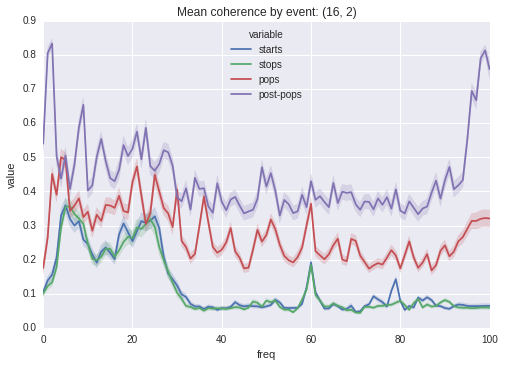

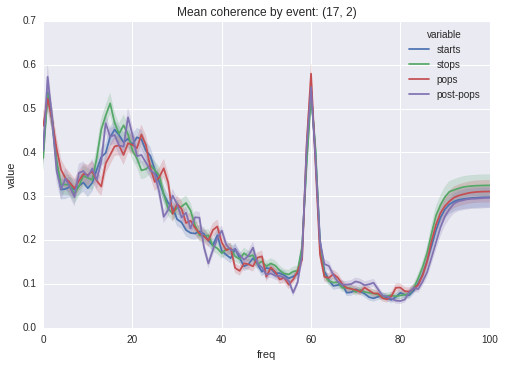

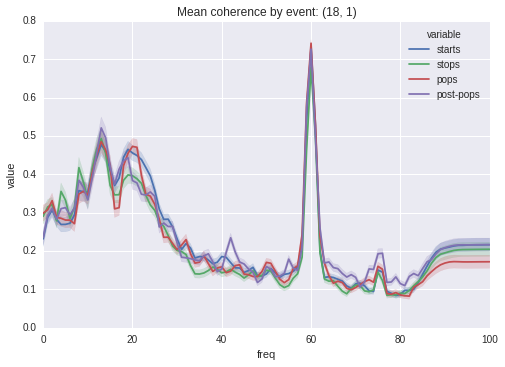

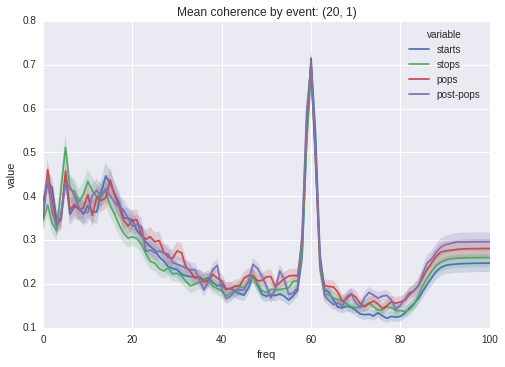

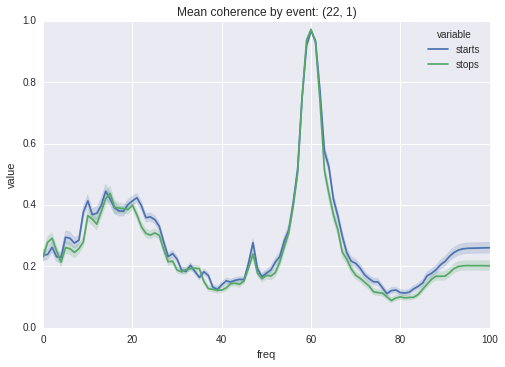

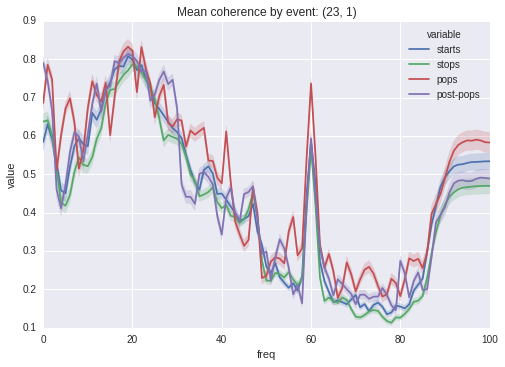

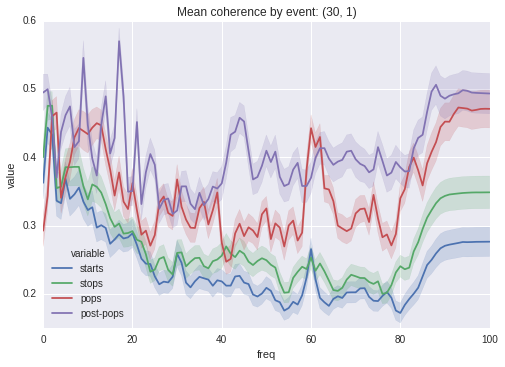

In [11]:
for dtup in tuplist:
    print dtup
    lfp = load_and_preprocess(dbname, dtup)

    nchan = lfp.shape[1]

    evt = dbio.fetch(dbname, 'events', *dtup)
    evtdict = {}
    evtdict['stops'] = evt['banked'].dropna()
    evtdict['pops'] = evt['popped'].dropna()
    evtdict['post-pops'] = evt['popped'].dropna()
    evtdict['starts'] = evt['start inflating']
    if 'is_control' in evt.columns:
        evtdict['stops_free'] = evt.query('is_control == False')['banked'].dropna()
        evtdict['stops_control'] = evt.query('is_control == True')['banked'].dropna()
        evtdict['stops_rewarded'] = evt.query('trial_type != 4')['banked'].dropna()
        evtdict['stops_unrewarded'] = evt.query('trial_type == 4')['banked'].dropna()
    else:
        evtdict['stops_free'] = evtdict['stops']
        evtdict['stops_control'] = None
        evtdict['stops_rewarded'] = evtdict['stops']
        evtdict['stops_unrewarded'] = None

    # process multiple events for each dataset
    events = ['starts', 'stops', 'pops', 'post-pops']

    coh_list = []
    ev_list = []
    rank_list = []
    for evtype in events:
        Tpre, Tpost = epoch_dict[evtype]

        nT = np.around((Tpost - Tpre)/dt).astype('int')

        # get chunks around each event
        lfp_split = lfp.evtsplit(evtdict[evtype], Tpre, Tpost)

        # get rid of all chunks containing nans
        lfp_list = [d for _, d in lfp_split.groupby(level=0) if not np.any(np.isnan(d.values))]

        # concatenate vertically back into dataframe
        if lfp_list:
            this_lfp = pd.concat(lfp_list)
            ev_list.append(evtype)
        else:
            continue

        # get coherence for all pairs of channels
        coh = get_coh_all_pairs(this_lfp, nT)

        # get effective rank of coherence matrix
        rframe = calc_rank_by_frequency(coh)
        rframe['event'] = evtype
        rank_list.append(rframe)

        # add coherence to list in tidy form
        coh_list.append(coh.stack())

    # concatenate data horizontally; make frequency a column    
    df = pd.concat(coh_list, axis=1).reset_index()
    df.columns = ["freq", "pair"] + ev_list

    # make data tidy for plotting
    df = pd.melt(df, id_vars=["freq", "pair"])

    rf = pd.concat(rank_list)

    plt.figure()
    sns.tsplot(data=df, time="freq", unit="pair",
               condition="variable", value="value",
               ci=95)
    plt.title('Mean coherence by event: ' + str(dtup));

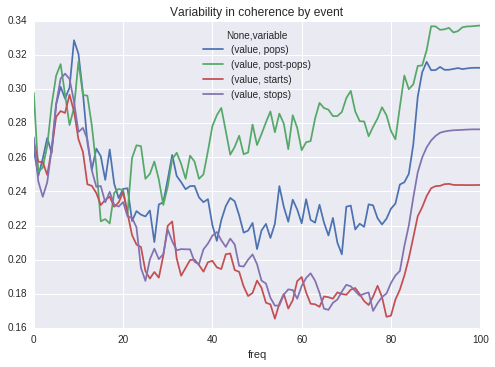

In [12]:
df.groupby(['freq', 'variable']).std().unstack().plot()
plt.title('Variability in coherence by event');

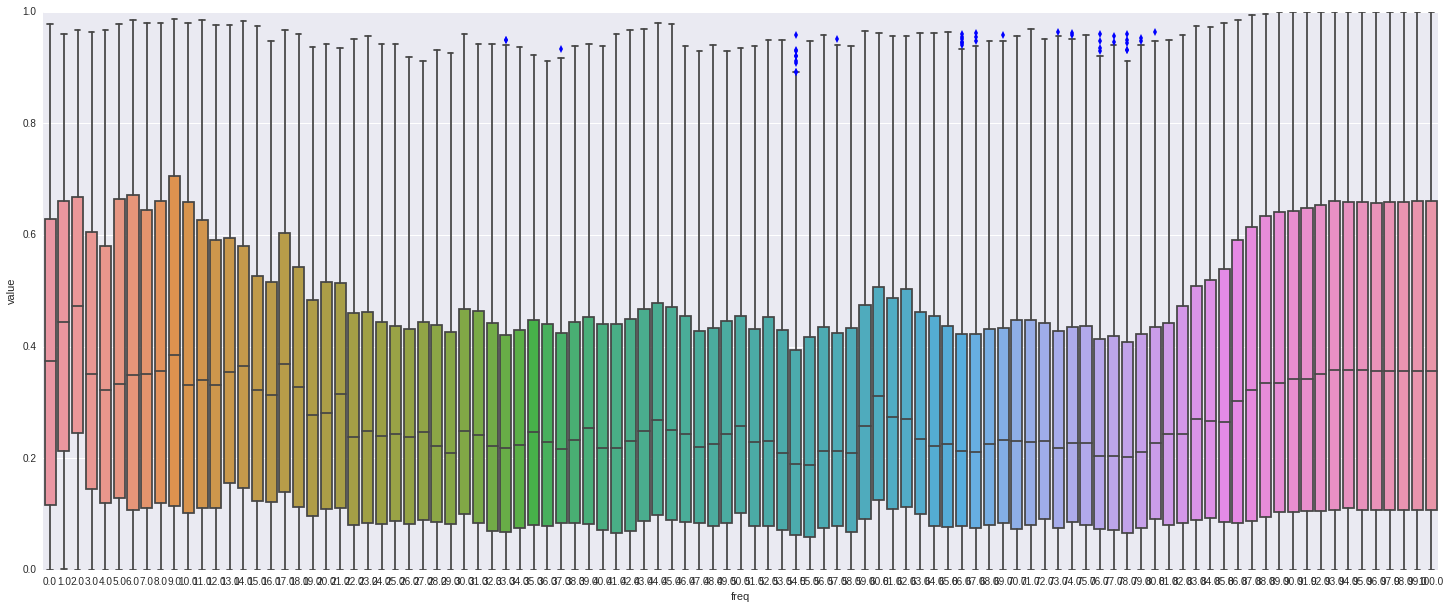

In [13]:
plt.figure(figsize=(25, 10))
sns.boxplot(data=df, x='freq', y='value')

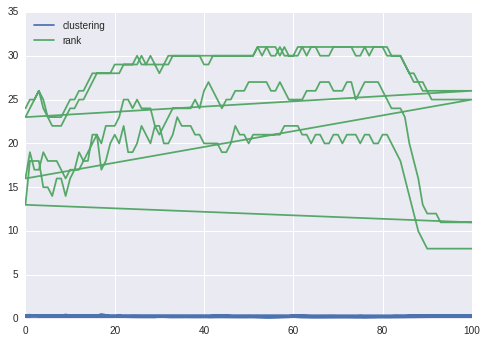

In [14]:
rf.plot()

In [15]:
rf.head()

,clustering,rank,event
0,0.293931,24,starts
1,0.400668,25,starts
2,0.387548,25,starts
3,0.271865,26,starts
4,0.262786,25,starts
